# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.6.0-gamma.fix.120.155.157'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
167559,2020-07-28,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167560,2020-07-29,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167561,2020-07-30,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167562,2020-07-31,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167563,2020-08-01,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
167559,2020-07-28,Colombia,Vichada,2,1,0,1
167560,2020-07-29,Colombia,Vichada,2,1,0,1
167561,2020-07-30,Colombia,Vichada,2,1,0,1
167562,2020-07-31,Colombia,Vichada,2,1,0,1
167563,2020-08-01,Colombia,Vichada,2,1,0,1


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
195,2020-07-28,11611,2819,328,8464
196,2020-07-29,11861,2774,329,8758
197,2020-07-30,12228,2789,330,9109
198,2020-07-31,12691,2921,332,9438
199,2020-08-01,13163,3393,332,9438


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-07-28,16726967,6383917,661746,9681304,0.019781,0.289392,0.063980
2020-07-29,17017811,6465418,668197,9884196,0.019632,0.290407,0.063322
2020-07-30,17324102,6579684,674122,10070296,0.019456,0.290644,0.062742
2020-07-31,17565090,6630459,680008,10254623,0.019357,0.291904,0.062188
2020-08-01,17566241,6656380,680008,10229853,0.019356,0.291179,0.062330


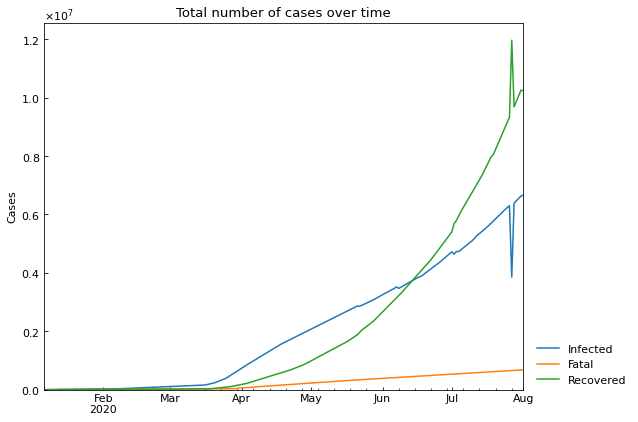

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
204,2020-07-28,32184,8377,1001,22806
205,2020-07-29,33448,8942,1005,23501
206,2020-07-30,34749,9569,1006,24174
207,2020-07-31,36330,10395,1012,24923
208,2020-08-01,37474,36462,1012,24523


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
167,2020-07-27,29969,6857,996,22116
168,2020-07-28,30961,7152,998,22811
169,2020-07-29,31901,7393,1001,23507
170,2020-07-30,33049,7866,1004,24179
171,2020-07-31,34372,8437,1006,24929


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
167559,2020-07-28,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167560,2020-07-29,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167561,2020-07-30,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167562,2020-07-31,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167563,2020-08-01,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
164359,COL,Colombia,Vichada,2020-07-28,107808
164360,COL,Colombia,Vichada,2020-07-29,107808
164361,COL,Colombia,Vichada,2020-07-30,107808
164362,COL,Colombia,Vichada,2020-07-31,107808
164363,COL,Colombia,Vichada,2020-08-01,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
167559,2020-07-28,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167560,2020-07-29,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167561,2020-07-30,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167562,2020-07-31,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
167563,2020-08-01,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
167559,2020-07-28,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
167560,2020-07-29,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
167561,2020-07-30,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
167562,2020-07-31,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
167563,2020-08-01,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04


In [23]:
# Subset for a country
oxcgrt_data.subset(country="Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
204,2020-07-28,1,1,1,0,0,1,1,3,2,2,1,32.41
205,2020-07-29,1,1,1,0,0,1,1,3,2,2,1,32.41
206,2020-07-30,1,1,1,0,0,1,1,3,2,2,1,32.41
207,2020-07-31,1,1,1,0,0,1,1,3,2,2,1,32.41
208,2020-08-01,1,1,1,0,0,1,1,3,2,2,1,32.41


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset(iso3="JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
204,2020-07-28,1,1,1,0,0,1,1,3,2,2,1,32.41
205,2020-07-29,1,1,1,0,0,1,1,3,2,2,1,32.41
206,2020-07-30,1,1,1,0,0,1,1,3,2,2,1,32.41
207,2020-07-31,1,1,1,0,0,1,1,3,2,2,1,32.41
208,2020-08-01,1,1,1,0,0,1,1,3,2,2,1,32.41


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

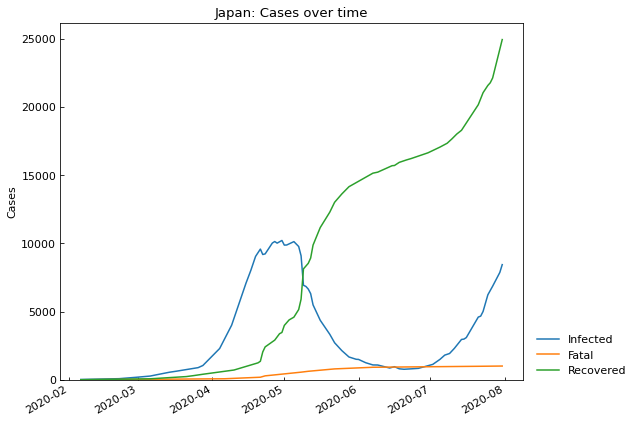

,Date,Confirmed,Infected,Fatal,Recovered
167,2020-07-27,29969,6857,996,22116
168,2020-07-28,30961,7152,998,22811
169,2020-07-29,31901,7393,1001,23507
170,2020-07-30,33049,7866,1004,24179
171,2020-07-31,34372,8437,1006,24929


In [26]:
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

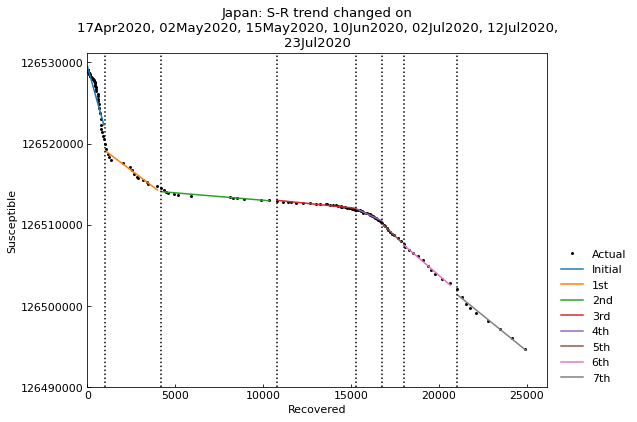

,Type,Start,End,Population
1st,Past,17Apr2020,01May2020,126529100
2nd,Past,02May2020,14May2020,126529100
3rd,Past,15May2020,09Jun2020,126529100
4th,Past,10Jun2020,01Jul2020,126529100
5th,Past,02Jul2020,11Jul2020,126529100
6th,Past,12Jul2020,22Jul2020,126529100
7th,Past,23Jul2020,31Jul2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<Main scenario: perform parameter estimation>

Running optimization with 8 CPUs...

	7th phase with SIR-F model finished 429 trials in 0 min 25 sec.

	1st phase with SIR-F model finished 177 trials in 0 min 10 sec.

	2nd phase with SIR-F model finished 115 trials in 0 min 5 sec.

	3rd phase with SIR-F model finished 194 trials in 0 min 10 sec.

	4th phase with SIR-F model finished 96 trials in 0 min 5 sec.

	5th phase with SIR-F model finished 152 trials in 0 min 10 sec.

	6th phase with SIR-F model finished 255 trials in 0 min 10 sec.

Completed optimization. Total: 2 min 41 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,rho,sigma,theta,kappa,tau,Rt,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
1st,Past,17Apr2020,01May2020,126529100,SIR-F,0.010953,0.004857,0.047160,0.000079,360,2.11,0.047,3148,22,51,0.137476,177,0 min 10 sec
2nd,Past,02May2020,14May2020,126529100,SIR-F,0.003900,0.012700,0.080455,0.000535,360,0.27,0.080,466,64,19,0.164932,115,0 min 5 sec
3rd,Past,15May2020,09Jun2020,126529100,SIR-F,0.005092,0.019894,0.292372,0.000193,360,0.18,0.292,1295,49,12,0.177698,194,0 min 10 sec
4th,Past,10Jun2020,01Jul2020,126529100,SIR-F,0.018544,0.018338,0.000590,0.001682,360,0.93,0.001,148,13,13,0.151204,96,0 min 5 sec
5th,Past,02Jul2020,11Jul2020,126529100,SIR-F,0.038414,0.016679,0.050413,0.000555,360,2.12,0.050,450,6,14,0.059369,152,0 min 10 sec
6th,Past,12Jul2020,22Jul2020,126529100,SIR-F,0.032695,0.016935,0.002934,0.000059,360,1.92,0.003,4203,7,14,0.025370,255,0 min 10 sec
7th,Past,23Jul2020,31Jul2020,126529100,SIR-F,0.033329,0.015231,0.000824,0.000859,360,2.07,0.001,291,7,16,0.066827,429,0 min 25 sec


### Accuracy of estimation

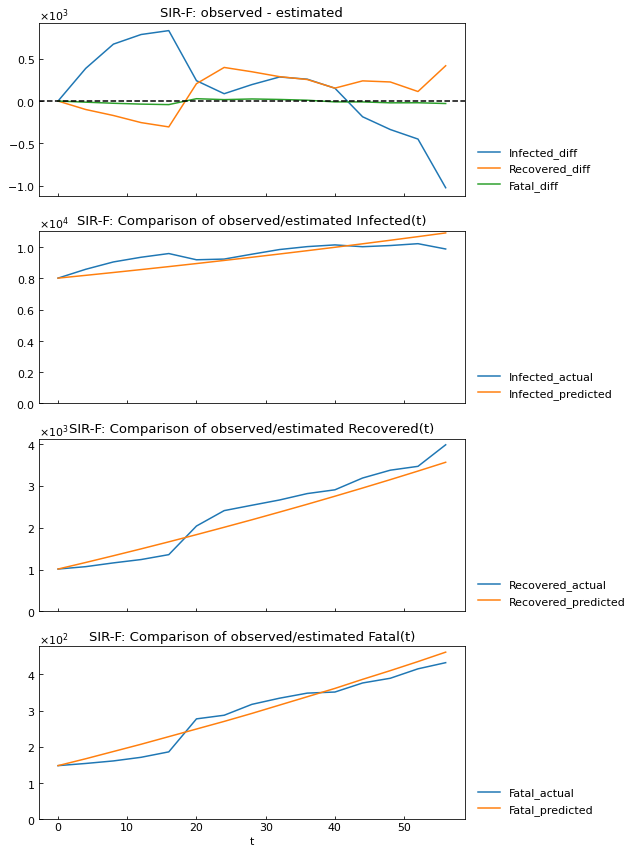

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

0.93

### Show parameter history

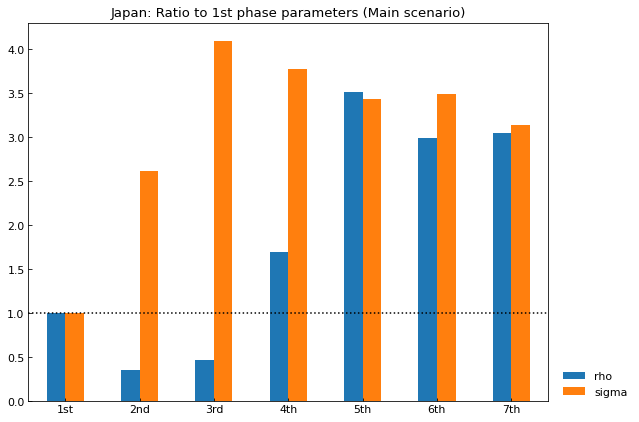

,1st,2nd,3rd,4th,5th,6th,7th
rho,1.0,0.356065,0.464893,1.693020,3.507112,2.985011,3.042891
sigma,1.0,2.614573,4.095576,3.775226,3.433837,3.486388,3.135634


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

### Show the history of reproduction number

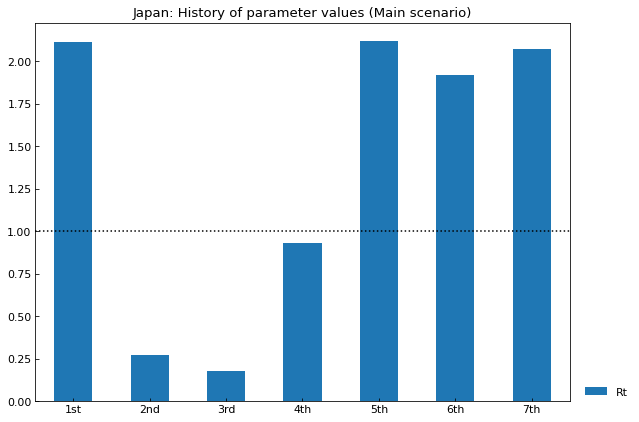

,1st,2nd,3rd,4th,5th,6th,7th
Rt,2.11,0.27,0.18,0.93,2.12,1.92,2.07


In [33]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

### Simulate the number of cases

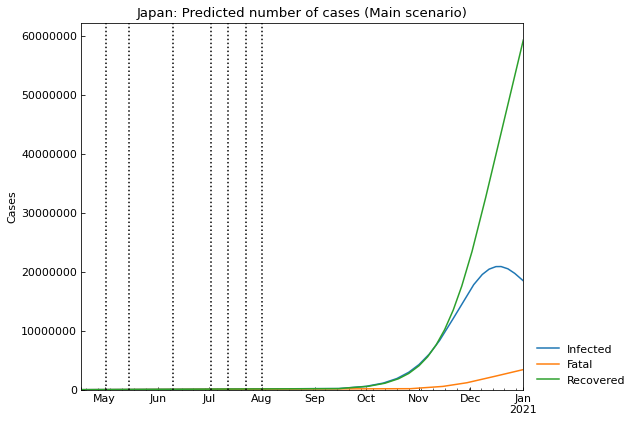

,Date,Fatal,Infected,Recovered,Susceptible
255,28Dec2020,3169815,19472648,55077790,48808847
256,29Dec2020,3237067,19211675,56256259,47824099
257,30Dec2020,3303368,18934855,57418343,46872535
258,31Dec2020,3368666,18643642,58563117,45953675
259,01Jan2021,3408990,18455446,59270166,45394500


In [34]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [35]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.01523085028398187

In [36]:
sigma_new = sigma_current * 2
sigma_new

0.03046170056796374

In [37]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE       rho  \
Scenario Phase                                                              
Main     0th      Past  17Apr2020  01May2020   126529100  SIR-F  0.010953   
         1st      Past  02May2020  14May2020   126529100  SIR-F  0.003900   
         2nd      Past  15May2020  09Jun2020   126529100  SIR-F  0.005092   
         3rd      Past  10Jun2020  01Jul2020   126529100  SIR-F  0.018544   
         4th      Past  02Jul2020  11Jul2020   126529100  SIR-F  0.038414   
         5th      Past  12Jul2020  22Jul2020   126529100  SIR-F  0.032695   
         6th      Past  23Jul2020  31Jul2020   126529100  SIR-F  0.033329   
         7th    Future  01Aug2020  01Jan2021   126529100  SIR-F  0.033329   
Medicine 0th      Past  17Apr2020  01May2020   126529100  SIR-F  0.010953   
         1st      Past  02May2020  14May2020   126529100  SIR-F  0.003900   
         2nd      Past  15May2020  09Jun2020   126529100  SIR-F  0.005092   
         3rd      Past  10Jun2020  01Jul2020   126529100  SIR-F  0.018544   
         4th      Past  02Jul2020  11Jul2020   126529100  SIR-F  0.038414   
         5th      Past  12Jul2020  22Jul2020   126529100  SIR-F  0.032695   
         6th      Past  23Jul2020  31Jul2020   126529100  SIR-F  0.033329   
         7th    Future  01Aug2020  31Aug2020   126529100  SIR-F  0.033329   
         8th    Future  01Sep2020  01Jan2021   126529100  SIR-F  0.033329   

                   sigma     theta     kappa  tau    Rt  alpha1 [-]  \
Scenario Phase                                                        
Main     0th    0.004857  0.047160  0.000079  360  2.11       0.047   
         1st    0.012700  0.080455  0.000535  360  0.27       0.080   
         2nd    0.019894  0.292372  0.000193  360  0.18       0.292   
         3rd    0.018338  0.000590  0.001682  360  0.93       0.001   
         4th    0.016679  0.050413  0.000555  360  2.12       0.050   
         5th    0.016935  0.002934  0.000059  360  1.92       0.003   
         6th    0.015231  0.000824  0.000859  360  2.07       0.001   
         7th    0.015231  0.000824  0.000859  360  2.07       0.001   
Medicine 0th    0.004857  0.047160  0.000079  360  2.11       0.047   
         1st    0.012700  0.080455  0.000535  360  0.27       0.080   
         2nd    0.019894  0.292372  0.000193  360  0.18       0.292   
         3rd    0.018338  0.000590  0.001682  360  0.93       0.001   
         4th    0.016679  0.050413  0.000555  360  2.12       0.050   
         5th    0.016935  0.002934  0.000059  360  1.92       0.003   
         6th    0.015231  0.000824  0.000859  360  2.07       0.001   
         7th    0.015231  0.000824  0.000859  360  2.07       0.001   
         8th    0.030462  0.000824  0.000859  360  1.06       0.001   

                1/alpha2 [day]  1/beta [day]  1/gamma [day]      RMSLE Trials  \
Scenario Phase                                                                  
Main     0th              3148            22             51   0.137476    177   
         1st               466            64             19   0.164932    115   
         2nd              1295            49             12   0.177698    194   
         3rd               148            13             13   0.151204     96   
         4th               450             6             14  0.0593688    152   
         5th              4203             7             14  0.0253698    255   
         6th               291             7             16  0.0668274    429   
         7th               291             7             16          -      -   
Medicine 0th              3148            22             51   0.137476    177   
         1st               466            64             19   0.164932    115   
         2nd              1295            49             12   0.177698    194   
         3rd               148            13             13   0.151204     96   
         4th               450             6             14  0.0593688

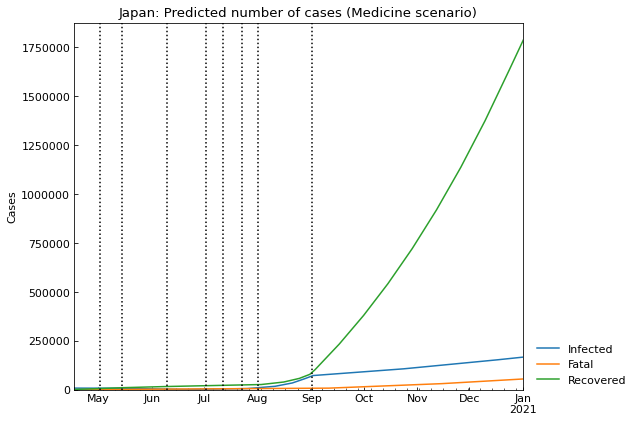

,Date,Fatal,Infected,Recovered,Susceptible
255,28Dec2020,52751,163121,1714340,124598888
256,29Dec2020,53330,164084,1734274,124577412
257,30Dec2020,53914,165048,1754326,124555813
258,31Dec2020,54500,166014,1774495,124534091
259,01Jan2021,54869,166619,1787157,124520458


In [38]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [39]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 01Jan2021,Fatal on 01Jan2021
Main,20902115,18Dec2020,18455446,3408990
Medicine,166619,01Jan2021,166619,54869
